In [1]:
from bertopic import BERTopic #import topic model

/home/kenny/anaconda3/envs/bertopic_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-14 00:48:15.132774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 00:48:15.132843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 00:48:15.134639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 00:48:15.146697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tensor

In [2]:
#data processing imports
import pandas as pd
import numpy as np
import tensorflow as tf
#cuML powered dimensional reduction & clustering
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP


In [3]:
import torch

In [4]:
print("TensorFlow version:", tf.__version__)

print("Is GPU available:", tf.test.is_gpu_available())

print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-14 00:49:31.059744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:49:31.072931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:49:31.073128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:49:49.829438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:49:49.829621: I external/local_xla/xla/stream_executor

In [6]:
import json
import tensorflow as tf
import os

folder_path = '/mnt/d/Thesis Notebooks/Thesis Data/Supreme Court Jurisprudence/10Years'

text_data = []  # List to store the text from each JSON file

for dirpath, dirnames, filenames in os.walk(folder_path):
    for file_name in filenames:
        if file_name.endswith('.json'):
            file_path = os.path.join(dirpath, file_name)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
                text = json_data['text']  # Extract only the text part
                text_data.append({'text': text})  # Append to the list as a dictionary

# Convert the list of dictionaries to a DataFrame
text_df = pd.DataFrame(text_data)

text_df.head()


,text
0,"Before us is a Complaint [1] dated May 17, 200..."
1,The administration of justice is circumscribed...
2,This administrative matter stemmed from a fina...
3,Before this Court is a Complaint [1] dated Jan...
4,The Case Before the Court is an administrative...


In [7]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10443 entries, 0 to 10442
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10443 non-null  object
dtypes: object(1)
memory usage: 81.7+ KB


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=2,max_df=0.95) #this need to be carefully handles kasi depende sa dataset size ata

In [9]:
import torch


# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. GPU details:")
    # Get the number of CUDA devices
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # Loop through available GPUs and print their details
    for i in range(num_gpus):
        print(f"GPU {i}: Name: {torch.cuda.get_device_name(i)}, Compute Capability: {torch.cuda.get_device_capability(i)}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available. GPU details:
Number of GPUs available: 1
GPU 0: Name: NVIDIA GeForce GTX 1060, Compute Capability: (6, 1)


In [10]:
# Initiate UMAP
import tensorflow as tf
import torch
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True, vectorizer_model=vectorizer_model)

# Run BERTopic model
topics, probabilities = topic_model.fit_transform(text_df['text'])

: 

In [10]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3409,-1_sale_lot_tax_writ,"[sale, lot, tax, writ, civil case, properties,...",[This resolves two (2) Petitions for Review on...
1,0,874,0_drugs_seized_dangerous_police,"[drugs, seized, dangerous, police, shabu, drug...",[The Case This is an appeal [1] filed pursuant...
2,1,630,1_aaa_rape_appellant_aaas,"[aaa, rape, appellant, aaas, sexual, victim, a...",[The subject of this appeal is the Decision [1...
3,2,579,2_complainant_lawyer_oca_client,"[complainant, lawyer, oca, client, complainant...",[Before this Court is a Verified Complaint-Aff...
4,3,531,3_victim_crime_accused_murder,"[victim, crime, accused, murder, treachery, ap...",[Before the Court is an ordinary appeal [1] fi...
...,...,...,...,...,...
83,82,11,82_forest_timber_lumber_truck,"[forest, timber, lumber, truck, environmental,...",[We resolve the petition for certiorari [1] fi...
84,83,11,83_marriage_spouse_children_dna,"[marriage, spouse, children, dna, family code,...","[Challenged in this petition is the October 2,..."
85,84,10,84_uy_batangas_residential_bataan,"[uy, batangas, residential, bataan, zip, lots,...",[Before us is a petition for review on certior...
86,85,10,85_proclamation_adverse claim_novai_2487,"[proclamation, adverse claim, novai, 2487, lan...","[In this Petition for Review, [1] the City of ..."


In [11]:
topic_model.get_topic(0)

[('drugs', 0.021477658202877264),
 ('seized', 0.01978997086858407),
 ('dangerous', 0.017274793757812747),
 ('police', 0.015854396348460205),
 ('shabu', 0.014612787535824335),
 ('drug', 0.014461887570714677),
 ('custody', 0.014293274555319195),
 ('dangerous drugs', 0.014074370797611688),
 ('9165', 0.014044422944940469),
 ('items', 0.013435951113636458)]

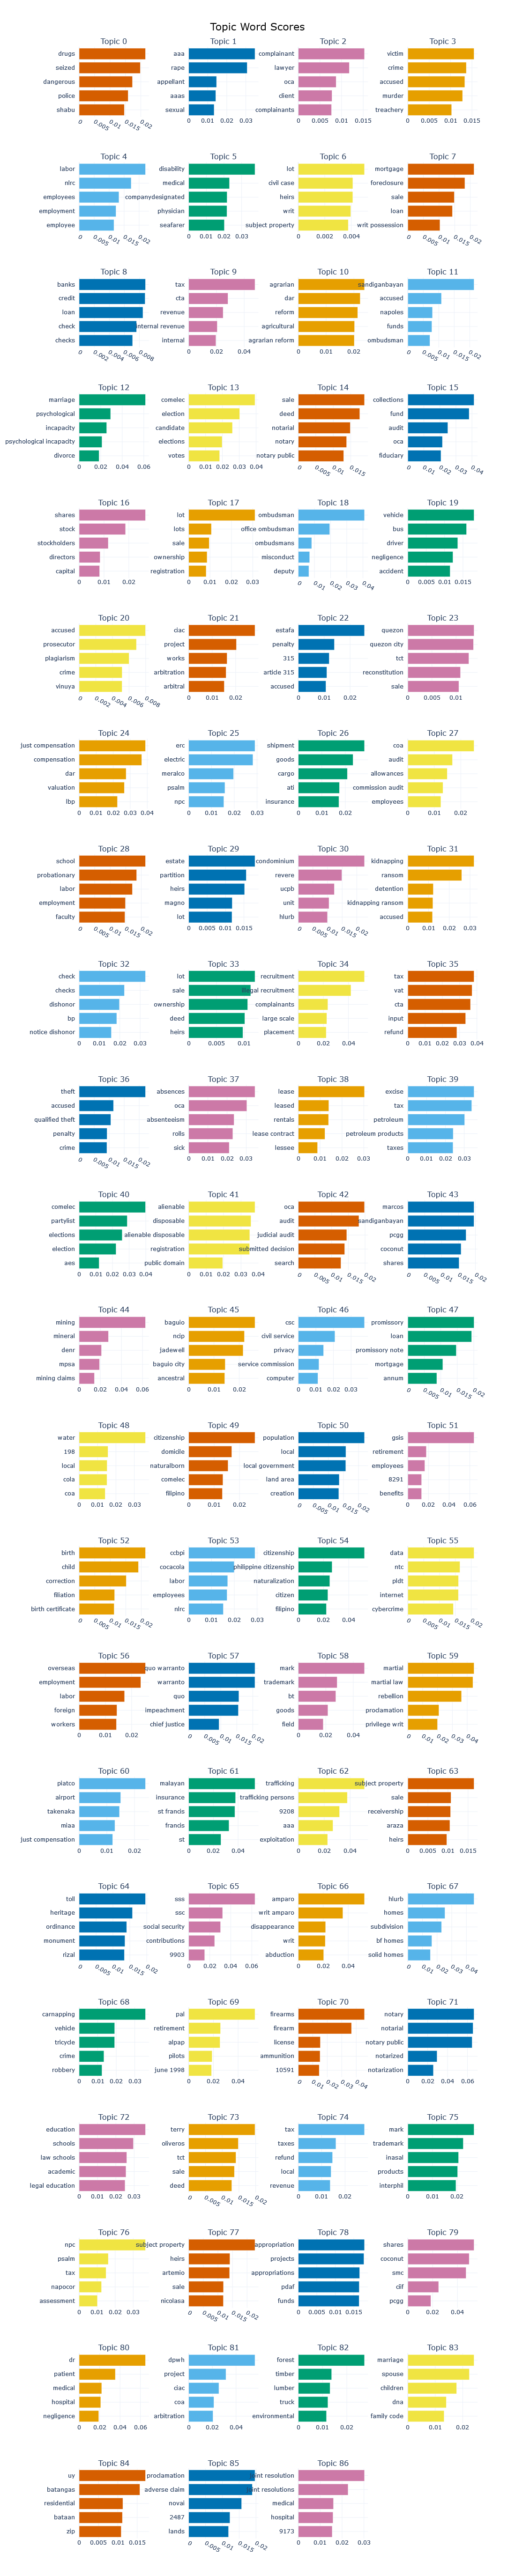

In [25]:
topic_model.visualize_barchart(top_n_topics=87)

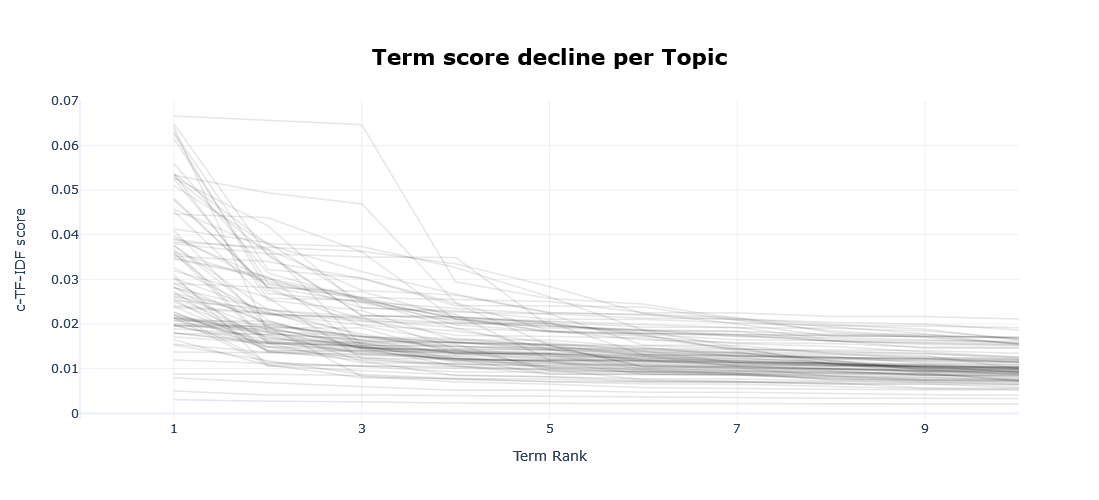

In [13]:
topic_model.visualize_term_rank()

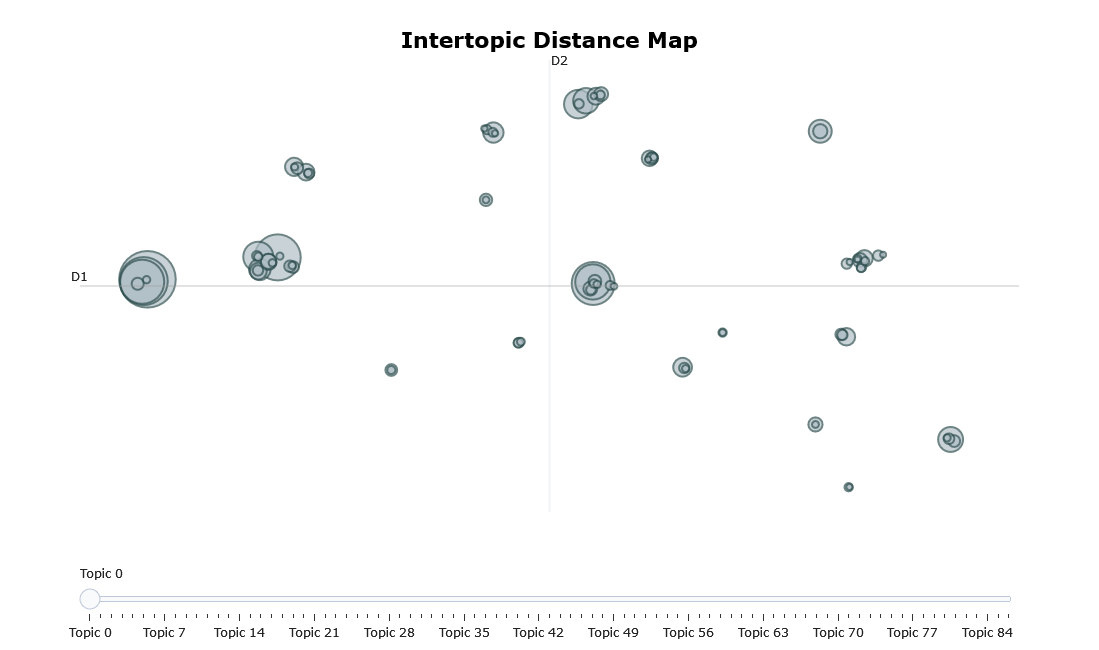

In [14]:
topic_model.visualize_topics()

In [28]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=12)

AttributeError: Module 'scipy' has no attribute 'array'

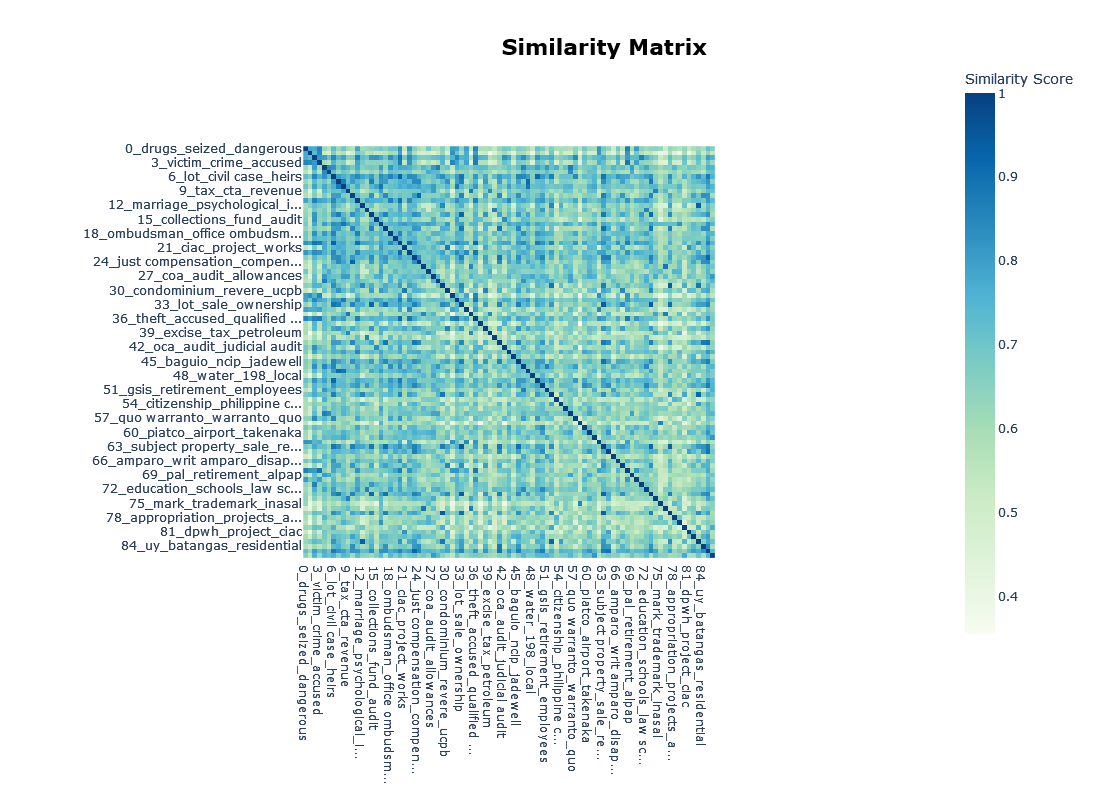

In [16]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

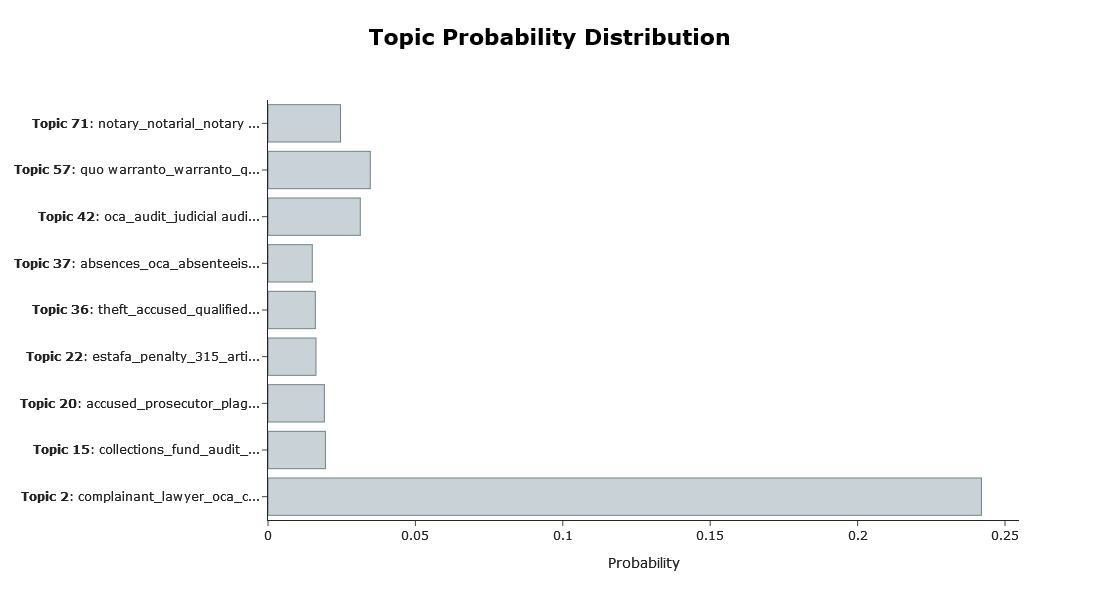

In [17]:
# Visualize probability distribution
topic_model.visualize_distribution(topic_model.probabilities_[1], min_probability=0.015)

In [19]:
# Save the chart to a variable
chart = topic_model.visualize_distribution(topic_model.probabilities_[0])

# Write the chart as a html file
chart.write_html("supremecourt_topic_probability(2010scountvectorizer)_distribution.html")

In [20]:
# Get probabilities for all topics
topic_model.probabilities_[0]

array([0.00381819, 0.00270033, 0.30949186, 0.00420182, 0.0052071 ,
       0.00373796, 0.0104366 , 0.00803792, 0.00856148, 0.00466594,
       0.00529632, 0.00878461, 0.01127151, 0.00617607, 0.00946348,
       0.01469634, 0.00752314, 0.00661285, 0.00854353, 0.0082153 ,
       0.01190724, 0.00641391, 0.01039121, 0.0081016 , 0.00537192,
       0.00472294, 0.00558334, 0.00648469, 0.00527006, 0.01036698,
       0.00701464, 0.00370331, 0.01389367, 0.00814638, 0.00369187,
       0.00448136, 0.00956084, 0.01158844, 0.00715779, 0.00486717,
       0.00635703, 0.00618646, 0.01741271, 0.0078848 , 0.00392958,
       0.00706758, 0.00779479, 0.00875984, 0.00613134, 0.0103274 ,
       0.00844684, 0.0073951 , 0.01137877, 0.00502172, 0.00708323,
       0.00585118, 0.00467533, 0.0232917 , 0.00578129, 0.0090115 ,
       0.00683774, 0.00784753, 0.00381587, 0.0073709 , 0.00668133,
       0.00631257, 0.00941558, 0.00676267, 0.00396121, 0.00516438,
       0.00415113, 0.05767136, 0.00781307, 0.00756504, 0.00495

In [21]:
# Get the topic predictions
topic_prediction = topic_model.topics_[:]

# Save the predictions in the dataframe
text_df['topic_prediction'] = topic_prediction

# Take a look at the data
text_df.head()

,text,topic_prediction
0,"Before us is a Complaint [1] dated May 17, 200...",2
1,The administration of justice is circumscribed...,2
2,This administrative matter stemmed from a fina...,15
3,Before this Court is a Complaint [1] dated Jan...,2
4,The Case Before the Court is an administrative...,-1


In [22]:
# New data for the review
new_text = "Andres and Priscilla robbed a bank and hurt some victims."

# Find topics
num_of_topics = 3
similar_topics, similarity = topic_model.find_topics(new_text, top_n=num_of_topics);

# Print results
print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')

The top 3 similar topics are [3, 36, 31], and the similarities are [0.45 0.45 0.42]


In [23]:
# Print the top keywords for the top similar topics
for i in range(num_of_topics):
  print(f'The top keywords for topic {similar_topics[i]} are:')
  print(topic_model.get_topic(similar_topics[i]))

The top keywords for topic 3 are:
[('victim', 0.015478731903725286), ('crime', 0.013669478962990238), ('accused', 0.013319387284760698), ('murder', 0.01279360226261001), ('treachery', 0.010243704128706534), ('appellant', 0.009746132508449348), ('accusedappellant', 0.009024865647847415), ('homicide', 0.0075660430185033895), ('killing', 0.007420005776275285), ('witness', 0.0072469440664570395)]
The top keywords for topic 36 are:
[('theft', 0.022070757555420425), ('accused', 0.011418252063641353), ('qualified theft', 0.010506712937231936), ('penalty', 0.009284250594942393), ('crime', 0.009221059391904676), ('stolen', 0.00885784239760994), ('robbery', 0.00866043436880643), ('carabao', 0.007586141444929377), ('qualified', 0.0073577370283934304), ('mary', 0.007057794378768403)]
The top keywords for topic 31 are:
[('kidnapping', 0.031927308879314734), ('ransom', 0.025960201596377575), ('detention', 0.012298040964664398), ('kidnapping ransom', 0.012095583479671962), ('accused', 0.0118897758595

In [24]:
# Save the topic model
topic_model.save("testing_topic_model")

# Load the topic model
my_model = BERTopic.load("testing_topic_model")

2024-02-12 21:02:46,439 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
